In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from io import BytesIO
from zipfile import ZipFile
from functools import partial
from functools import lru_cache
from urllib.request import urlopen
from collections import defaultdict
from matplotlib import pyplot as plt

In [2]:
def make_primate_graph():
    resp = urlopen("http://www.complex-networks.net/datasets/primates.zip")
    zipfile = ZipFile(BytesIO(resp.read()))
    primate_data = zipfile.open('primates/primates.net').read()
    df = pd.read_csv(BytesIO(primate_data), sep=' ', header=None)
    G = nx.Graph()
    for ind, (v1, v2) in df.iterrows():
        G.add_edge(v1, v2)
    return G

In [3]:
def make_fc(n):
    return nx.complete_graph(n)

def make_bp(n, m, p):
    return nx.bipartite.random_graph(n, m, p)

def make_rand_fc(n, p):
    g = nx.gnp_random_graph(n, p)
    while not nx.is_connected(g):
        g = nx.gnp_random_graph(n, p)
    return g

In [4]:
def make_slide11():
    g = nx.Graph()
    edges = [(7,5), (6,5), (7,6), (5,4),
             (4,3), (3,2), (2,1), (3,1)]
    g.add_edges_from(edges)
    return g

def make_slide12():
    g = nx.Graph()
    edges = '''
    r-q q-o o-m m-n m-l
    m-p t-q e-s p-s t-l
    l-k k-j k-i k-h h-f
    f-g f-e f-d d-c c-s
    s-t s-r'''
    edges = edges.replace('\n', ' ')
    for e in edges.split():
        v1, v2 = e.split('-')
        g.add_edge(v1, v2)
    return g

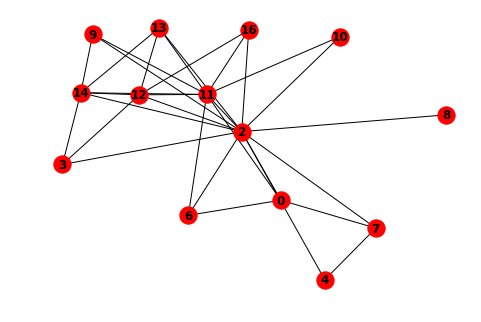

In [5]:
G = make_primate_graph()
nx.draw(G, with_labels=True, font_weight='bold')

In [6]:
def deg_cent(n):
    return len(list(G.neighbors(n)))

def norm_deg_cent(n):
    return deg_cent(n) / (len(G.nodes) - 1)

In [7]:
def bonacich_eigen_cent(n):
    n_ = list(G.nodes).index(n)
    A = nx.to_numpy_matrix(G)
    evals, evects = np.linalg.eig(A)
    max_eval_ind = np.argmax(evals, axis=0)
    return evects.T[max_eval_ind, n_].real

def norm_bonacich_eigen_cent(n):
    sum_ = sum(map(bonacich_eigen_cent, G.nodes))
    return bonacich_eigen_cent(n) / sum_

In [8]:
def alpha_cent(n, alpha=0.1):
    n_ = list(G.nodes).index(n)
    A = nx.convert_matrix.to_numpy_array(G)
    c_alpha = np.linalg.inv(np.eye(*A.shape) - alpha*A.T)
    e = np.ones(len(G.nodes))
    return float(np.matmul(c_alpha, e)[n_])

def norm_alpha_cent(n, alpha=0.1):
    cent_fn = partial(alpha_cent, alpha=alpha)
    norm = sum(map(cent_fn, G.nodes))
    return alpha_cent(n) / norm

In [9]:
def closeness_cent(n):
    di = lambda j: nx.shortest_path_length(G, n, j)
    return 1./sum(map(di, G.nodes))

def norm_closeness_cent(n):
    N = len(G.nodes)
    return (N-1) * closeness_cent(n)

In [10]:
CACHE_SIZE = 1000

@lru_cache(maxsize=CACHE_SIZE)
def geodesics(G, n, m):
    return len(list(nx.all_shortest_paths(G, n, m)))

@lru_cache(maxsize=CACHE_SIZE)
def get_paths(G, n, m):
    return list(nx.all_simple_paths(G, n, m))

@lru_cache(maxsize=CACHE_SIZE)
def geodesics_contains(G, n, m, contain):
    contains = lambda path: contain in path
    paths = list(nx.all_shortest_paths(G, n, m))
    valid_paths = list(filter(contains, paths))
    return len(valid_paths)

def between_cent(n):
    total = 0
    for j in G.nodes:
        if n == j: continue
        for k in G.nodes:
            if k in [n, j]: continue
            num = geodesics_contains(G, j, k, n)
            den = geodesics(G, j, k)
            total += float(num) / den
    return total

def norm_between_cent(n):
    n_ = len(G.nodes)
    return between_cent(n)/((n_-1)*(n_-2))

In [11]:
def delta_cent(n, P):
    G_ = G.copy()
    G_.remove_node(n)
    return (P(G) - P(G_))/P(G)

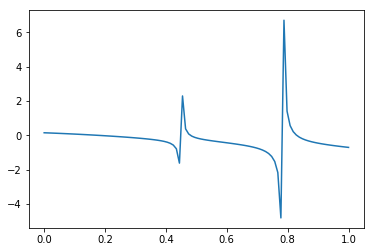

In [14]:
given_node = list(G.nodes)[0]
xs = np.linspace(0, 1, num=100)

plt.plot(xs, [norm_alpha_cent(given_node, a) for a in xs])

==== K7 ====

--- Node 0 ---
Degree: 1.00
Bonacich: 0.14
Alpha: 0.14
Closeness: 1.00
Between_Cent: 0.00

--- Node 1 ---
Degree: 1.00
Bonacich: 0.14
Alpha: 0.14
Closeness: 1.00
Between_Cent: 0.00

--- Node 2 ---
Degree: 1.00
Bonacich: 0.14
Alpha: 0.14
Closeness: 1.00
Between_Cent: 0.00

--- Node 3 ---
Degree: 1.00
Bonacich: 0.14
Alpha: 0.14
Closeness: 1.00
Between_Cent: 0.00

--- Node 4 ---
Degree: 1.00
Bonacich: 0.14
Alpha: 0.14
Closeness: 1.00
Between_Cent: 0.00

--- Node 5 ---
Degree: 1.00
Bonacich: 0.14
Alpha: 0.14
Closeness: 1.00
Between_Cent: 0.00

--- Node 6 ---
Degree: 1.00
Bonacich: 0.14
Alpha: 0.14
Closeness: 1.00
Between_Cent: 0.00


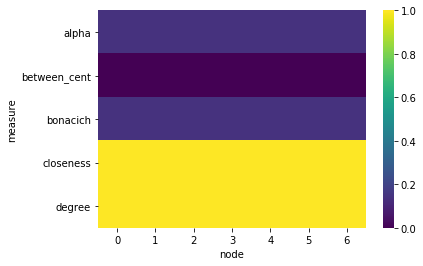

==== Rand 7 (0.5) ====

--- Node 0 ---
Degree: 0.17
Bonacich: 0.02
Alpha: 0.12
Closeness: 0.33
Between_Cent: 0.00

--- Node 1 ---
Degree: 0.33
Bonacich: 0.18
Alpha: 0.14
Closeness: 0.46
Between_Cent: 0.00

--- Node 2 ---
Degree: 0.67
Bonacich: 0.25
Alpha: 0.17
Closeness: 0.67
Between_Cent: 0.63

--- Node 3 ---
Degree: 0.33
Bonacich: 0.18
Alpha: 0.14
Closeness: 0.46
Between_Cent: 0.00

--- Node 4 ---
Degree: 0.33
Bonacich: 0.11
Alpha: 0.14
Closeness: 0.60
Between_Cent: 0.53

--- Node 5 ---
Degree: 0.33
Bonacich: 0.05
Alpha: 0.14
Closeness: 0.46
Between_Cent: 0.33

--- Node 6 ---
Degree: 0.50
Bonacich: 0.22
Alpha: 0.15
Closeness: 0.50
Between_Cent: 0.03


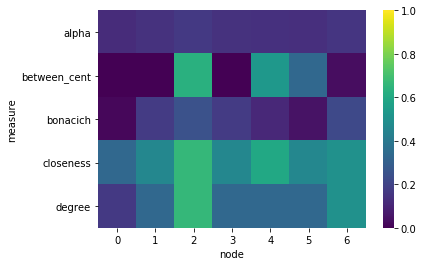

==== BP 7-7 (0.5) ====

--- Node 0 ---
Degree: 0.15
Bonacich: 0.03
Alpha: 0.06
Closeness: 0.39
Between_Cent: 0.02

--- Node 1 ---
Degree: 0.23
Bonacich: 0.07
Alpha: 0.07
Closeness: 0.45
Between_Cent: 0.02

--- Node 2 ---
Degree: 0.23
Bonacich: 0.05
Alpha: 0.07
Closeness: 0.48
Between_Cent: 0.06

--- Node 3 ---
Degree: 0.38
Bonacich: 0.10
Alpha: 0.08
Closeness: 0.57
Between_Cent: 0.17

--- Node 4 ---
Degree: 0.38
Bonacich: 0.10
Alpha: 0.08
Closeness: 0.57
Between_Cent: 0.17

--- Node 5 ---
Degree: 0.15
Bonacich: 0.04
Alpha: 0.06
Closeness: 0.42
Between_Cent: 0.02

--- Node 6 ---
Degree: 0.38
Bonacich: 0.10
Alpha: 0.08
Closeness: 0.57
Between_Cent: 0.17

--- Node 7 ---
Degree: 0.38
Bonacich: 0.10
Alpha: 0.08
Closeness: 0.57
Between_Cent: 0.19

--- Node 8 ---
Degree: 0.31
Bonacich: 0.09
Alpha: 0.08
Closeness: 0.52
Between_Cent: 0.07

--- Node 9 ---
Degree: 0.23
Bonacich: 0.06
Alpha: 0.07
Closeness: 0.45
Between_Cent: 0.06

--- Node 10 ---
Degree: 0.31
Bonacich: 0.08
Alpha: 0.07
Closeness:

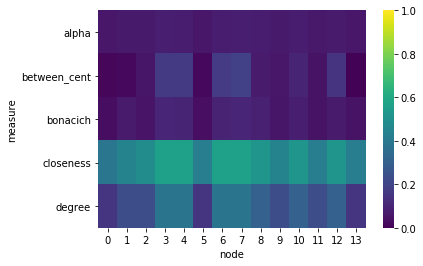

==== Slide 11 ====

--- Node 7 ---
Degree: 0.33
Bonacich: 0.13
Alpha: 0.14
Closeness: 0.40
Between_Cent: 0.00

--- Node 5 ---
Degree: 0.50
Bonacich: 0.17
Alpha: 0.15
Closeness: 0.55
Between_Cent: 0.53

--- Node 6 ---
Degree: 0.33
Bonacich: 0.13
Alpha: 0.14
Closeness: 0.40
Between_Cent: 0.00

--- Node 4 ---
Degree: 0.33
Bonacich: 0.15
Alpha: 0.14
Closeness: 0.60
Between_Cent: 0.60

--- Node 3 ---
Degree: 0.50
Bonacich: 0.17
Alpha: 0.15
Closeness: 0.55
Between_Cent: 0.53

--- Node 2 ---
Degree: 0.33
Bonacich: 0.13
Alpha: 0.14
Closeness: 0.40
Between_Cent: 0.00

--- Node 1 ---
Degree: 0.33
Bonacich: 0.13
Alpha: 0.14
Closeness: 0.40
Between_Cent: 0.00


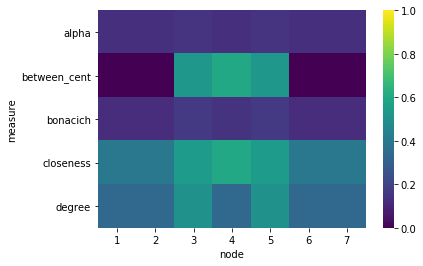

==== Slide 12 ====

--- Node r ---
Degree: 0.12
Bonacich: 0.07
Alpha: 0.05
Closeness: 0.34
Between_Cent: 0.04

--- Node q ---
Degree: 0.18
Bonacich: 0.07
Alpha: 0.06
Closeness: 0.35
Between_Cent: 0.07

--- Node o ---
Degree: 0.12
Bonacich: 0.05
Alpha: 0.05
Closeness: 0.31
Between_Cent: 0.02

--- Node m ---
Degree: 0.24
Bonacich: 0.08
Alpha: 0.06
Closeness: 0.40
Between_Cent: 0.21

--- Node n ---
Degree: 0.06
Bonacich: 0.03
Alpha: 0.05
Closeness: 0.29
Between_Cent: 0.00

--- Node l ---
Degree: 0.18
Bonacich: 0.08
Alpha: 0.06
Closeness: 0.44
Between_Cent: 0.26

--- Node p ---
Degree: 0.12
Bonacich: 0.07
Alpha: 0.05
Closeness: 0.39
Between_Cent: 0.09

--- Node t ---
Degree: 0.18
Bonacich: 0.09
Alpha: 0.06
Closeness: 0.44
Between_Cent: 0.16

--- Node e ---
Degree: 0.12
Bonacich: 0.06
Alpha: 0.05
Closeness: 0.39
Between_Cent: 0.12

--- Node s ---
Degree: 0.29
Bonacich: 0.12
Alpha: 0.07
Closeness: 0.45
Between_Cent: 0.33

--- Node k ---
Degree: 0.24
Bonacich: 0.05
Alpha: 0.06
Closeness: 0.40

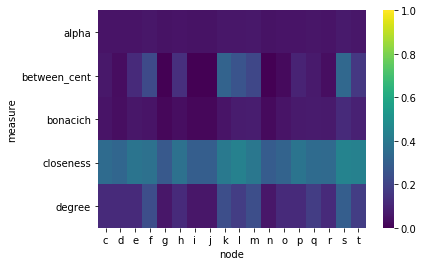

==== Primates ====

--- Node 0 ---
Degree: 0.31
Bonacich: 0.06
Alpha: 0.07
Closeness: 0.59
Between_Cent: 0.01

--- Node 6 ---
Degree: 0.23
Bonacich: 0.06
Alpha: 0.06
Closeness: 0.57
Between_Cent: 0.00

--- Node 7 ---
Degree: 0.23
Bonacich: 0.04
Alpha: 0.06
Closeness: 0.57
Between_Cent: 0.01

--- Node 11 ---
Degree: 0.69
Bonacich: 0.12
Alpha: 0.10
Closeness: 0.76
Between_Cent: 0.13

--- Node 10 ---
Degree: 0.15
Bonacich: 0.05
Alpha: 0.06
Closeness: 0.54
Between_Cent: 0.00

--- Node 9 ---
Degree: 0.23
Bonacich: 0.06
Alpha: 0.06
Closeness: 0.57
Between_Cent: 0.00

--- Node 4 ---
Degree: 0.15
Bonacich: 0.03
Alpha: 0.05
Closeness: 0.54
Between_Cent: 0.00

--- Node 2 ---
Degree: 1.00
Bonacich: 0.15
Alpha: 0.12
Closeness: 1.00
Between_Cent: 0.57

--- Node 3 ---
Degree: 0.23
Bonacich: 0.06
Alpha: 0.06
Closeness: 0.57
Between_Cent: 0.00

--- Node 8 ---
Degree: 0.08
Bonacich: 0.03
Alpha: 0.05
Closeness: 0.52
Between_Cent: 0.00

--- Node 12 ---
Degree: 0.46
Bonacich: 0.10
Alpha: 0.08
Closeness: 0

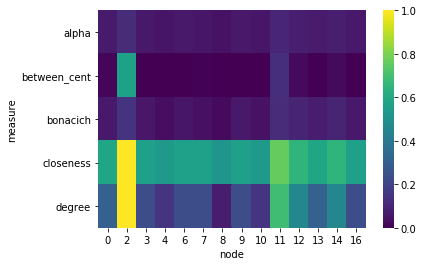

In [15]:
PRINT = True
graphs = {
    'K7': make_fc(7),
    'Rand 7 (0.5)': make_rand_fc(7, 0.5),
    'BP 7-7 (0.5)': make_bp(7, 7, 0.5),
    'Slide 11': make_slide11(),
    'Slide 12': make_slide12(),
    'Primates': make_primate_graph()
}
measures = {
    'degree': norm_deg_cent,
    'bonacich': norm_bonacich_eigen_cent,
    'alpha': norm_alpha_cent,
    'closeness': norm_closeness_cent,
    'between_cent': norm_between_cent
}

for graph_name, G in graphs.items():
    print("==== {} ====".format(graph_name))
    closeness = defaultdict(list)
    for node in G.nodes:
        if PRINT: print("\n--- Node {} ---".format(node))
        for name, cent_fn in measures.items():
            cent = cent_fn(node)
            assert 0 <= cent <= 1, (name, cent)
            if PRINT: print("{}: {:.2f}".format(name.title(), cent))
            closeness['closeness'].append(cent)
            closeness['measure'].append(name)
            closeness['node'].append(node)

    df = pd.DataFrame.from_dict(closeness)
    sns.heatmap(df.pivot('measure', 'node', 'closeness'),
               vmin=0., vmax=1., cmap='viridis')
    plt.show()